In [2]:
# ==============================================================
# Fashion-MNIST Coursework Implementation (PyTorch)
# Implements both ANN and CNN models, with training/validation,
# evaluation, confusion matrices, and performance comparison.
# ==============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
# --------------------------------------------------------------
# 1. Data Loading & Preprocessing
# --------------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split training set into train/validation (80/20)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 229kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.27MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.1MB/s]


In [4]:
# --------------------------------------------------------------
# 2. Model Definitions
# --------------------------------------------------------------
class ANN(nn.Module):
    """A simple Multi-Layer Perceptron (MLP) for classification."""
    def __init__(self):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)


class CNN(nn.Module):
    """A simple Convolutional Neural Network for image classification."""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


In [5]:
# --------------------------------------------------------------
# 3. Training Function
# --------------------------------------------------------------
def train_model(model, train_loader, val_loader, epochs=5, lr=0.001):
    """Train the model and record training/validation losses and accuracy."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # --- Validation ---
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | "
              f"Val Acc: {acc:.2f}%")

    return train_losses, val_losses, val_accuracies

In [6]:
# --------------------------------------------------------------
# 4. Instantiate and Train Models
# --------------------------------------------------------------
ann = ANN()
cnn = CNN()

print("\n=== Training ANN ===")
ann_train_loss, ann_val_loss, ann_val_acc = train_model(ann, train_loader, val_loader, epochs=5)

print("\n=== Training CNN ===")
cnn_train_loss, cnn_val_loss, cnn_val_acc = train_model(cnn, train_loader, val_loader, epochs=5)



=== Training ANN ===
Epoch [1/5] Train Loss: 0.5574 | Val Loss: 0.4569 | Val Acc: 83.07%
Epoch [2/5] Train Loss: 0.4249 | Val Loss: 0.3676 | Val Acc: 86.78%
Epoch [3/5] Train Loss: 0.3910 | Val Loss: 0.3490 | Val Acc: 87.48%
Epoch [4/5] Train Loss: 0.3694 | Val Loss: 0.3390 | Val Acc: 87.75%
Epoch [5/5] Train Loss: 0.3523 | Val Loss: 0.3297 | Val Acc: 88.18%

=== Training CNN ===
Epoch [1/5] Train Loss: 0.5651 | Val Loss: 0.3405 | Val Acc: 87.47%
Epoch [2/5] Train Loss: 0.3698 | Val Loss: 0.2852 | Val Acc: 89.77%
Epoch [3/5] Train Loss: 0.3176 | Val Loss: 0.2547 | Val Acc: 90.76%
Epoch [4/5] Train Loss: 0.2811 | Val Loss: 0.2351 | Val Acc: 91.54%
Epoch [5/5] Train Loss: 0.2570 | Val Loss: 0.2308 | Val Acc: 91.79%



ANN Test Accuracy: 86.98%


<Figure size 800x600 with 0 Axes>

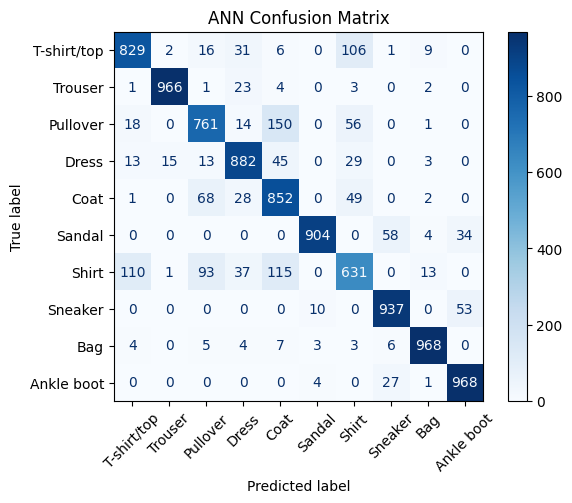


CNN Test Accuracy: 90.79%


<Figure size 800x600 with 0 Axes>

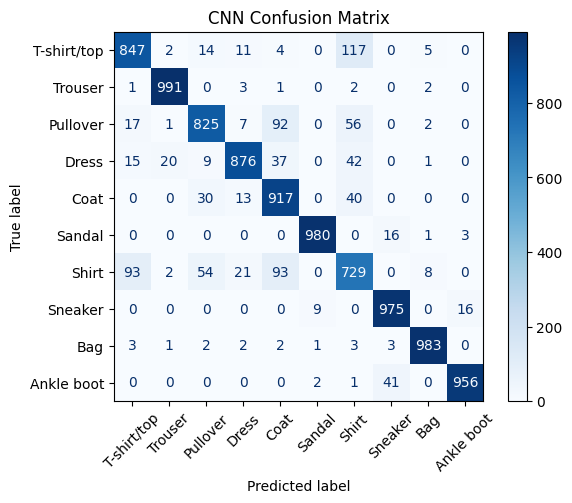

In [7]:
# --------------------------------------------------------------
# 5. Evaluation & Confusion Matrix
# --------------------------------------------------------------
def evaluate_model(model, test_loader, model_name="Model"):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * correct / total
    print(f"\n{model_name} Test Accuracy: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    ConfusionMatrixDisplay(cm, display_labels=test_data.classes).plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return acc

# Evaluate both models
ann_test_acc = evaluate_model(ann, test_loader, "ANN")
cnn_test_acc = evaluate_model(cnn, test_loader, "CNN")


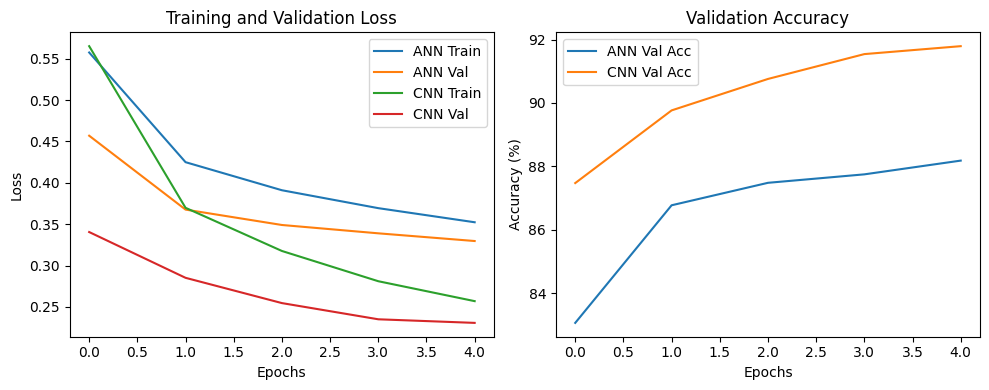

In [8]:
# --------------------------------------------------------------
# 6. Performance Visualization
# --------------------------------------------------------------
plt.figure(figsize=(10,4))

# --- Loss Curves ---
plt.subplot(1,2,1)
plt.plot(ann_train_loss, label='ANN Train')
plt.plot(ann_val_loss, label='ANN Val')
plt.plot(cnn_train_loss, label='CNN Train')
plt.plot(cnn_val_loss, label='CNN Val')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- Validation Accuracy ---
plt.subplot(1,2,2)
plt.plot(ann_val_acc, label='ANN Val Acc')
plt.plot(cnn_val_acc, label='CNN Val Acc')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# --------------------------------------------------------------
# 7. Comparison Summary
# --------------------------------------------------------------
print("\n========== FINAL ACCURACY COMPARISON ==========")
print(f"ANN Test Accuracy : {ann_test_acc:.2f}%")
print(f"CNN Test Accuracy : {cnn_test_acc:.2f}%")
print(f"Accuracy Difference: {cnn_test_acc - ann_test_acc:.2f}%")

if cnn_test_acc > ann_test_acc:
    print(" CNN outperforms ANN — due to convolution layers capturing spatial features.")
else:
    print("ANN performed better — consider tuning CNN hyperparameters or regularization.")


========== FINAL ACCURACY COMPARISON ==========
ANN Test Accuracy : 86.98%
CNN Test Accuracy : 90.79%
Accuracy Difference: 3.81%
 CNN outperforms ANN — due to convolution layers capturing spatial features.


In [10]:
# ==============================================================
# Improved Fashion-MNIST Classification
# Includes Data Augmentation, BatchNorm, Dropout tuning,
# and Learning Rate Scheduler for better accuracy.
# ==============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
# --------------------------------------------------------------
# 1. Data Loading with Augmentation
# --------------------------------------------------------------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

# Split training set into train/validation (80/20)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
# --------------------------------------------------------------
# 2. Improved ANN Model
# --------------------------------------------------------------
class ANNImproved(nn.Module):
    def __init__(self):
        super(ANNImproved, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)


In [13]:
# --------------------------------------------------------------
# 3. Improved CNN Model
# --------------------------------------------------------------
class CNNImproved(nn.Module):
    def __init__(self):
        super(CNNImproved, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [14]:
# --------------------------------------------------------------
# 4. Training Function (with LR Scheduler)
# --------------------------------------------------------------
def train_model(model, train_loader, val_loader, epochs=15, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

    model.to(device)
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        scheduler.step()

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | "
              f"Val Acc: {acc:.2f}%")

    return train_losses, val_losses, val_accuracies

In [15]:
# --------------------------------------------------------------
# 5. Instantiate and Train Both Models
# --------------------------------------------------------------
ann_improved = ANNImproved()
cnn_improved = CNNImproved()

print("\n=== Training Improved ANN ===")
ann_train_loss, ann_val_loss, ann_val_acc = train_model(ann_improved, train_loader, val_loader, epochs=5)

print("\n=== Training Improved CNN ===")
cnn_train_loss, cnn_val_loss, cnn_val_acc = train_model(cnn_improved, train_loader, val_loader, epochs=5)



=== Training Improved ANN ===
Epoch [1/5] Train Loss: 0.8344 | Val Loss: 0.6791 | Val Acc: 73.99%
Epoch [2/5] Train Loss: 0.7035 | Val Loss: 0.6090 | Val Acc: 76.25%
Epoch [3/5] Train Loss: 0.6622 | Val Loss: 0.5707 | Val Acc: 78.38%
Epoch [4/5] Train Loss: 0.6378 | Val Loss: 0.5421 | Val Acc: 79.48%
Epoch [5/5] Train Loss: 0.6225 | Val Loss: 0.5363 | Val Acc: 79.35%

=== Training Improved CNN ===
Epoch [1/5] Train Loss: 0.8223 | Val Loss: 0.5157 | Val Acc: 80.00%
Epoch [2/5] Train Loss: 0.6127 | Val Loss: 0.4571 | Val Acc: 82.37%
Epoch [3/5] Train Loss: 0.5464 | Val Loss: 0.4155 | Val Acc: 84.29%
Epoch [4/5] Train Loss: 0.5123 | Val Loss: 0.3815 | Val Acc: 85.35%
Epoch [5/5] Train Loss: 0.4793 | Val Loss: 0.3930 | Val Acc: 84.84%



Improved ANN Test Accuracy: 81.78%


<Figure size 800x600 with 0 Axes>

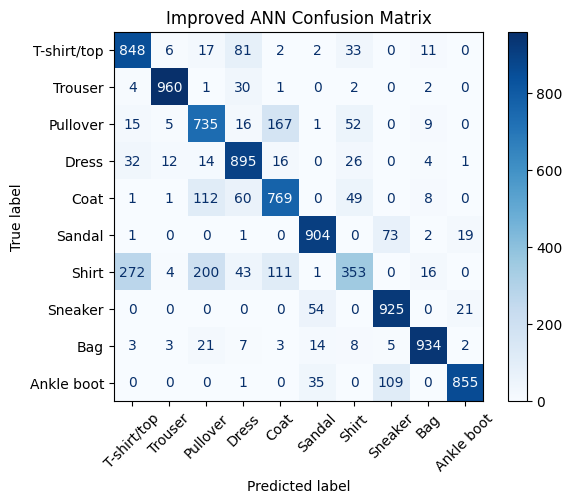


Improved CNN Test Accuracy: 86.52%


<Figure size 800x600 with 0 Axes>

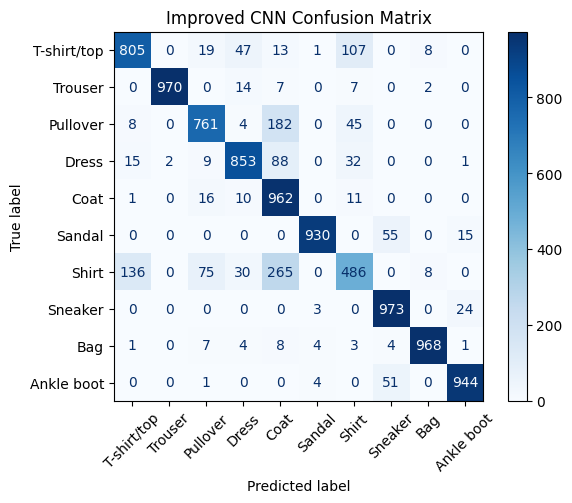

In [16]:
# --------------------------------------------------------------
# 6. Evaluation and Confusion Matrix
# --------------------------------------------------------------
def evaluate_model(model, test_loader, model_name="Model"):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * correct / total
    print(f"\n{model_name} Test Accuracy: {acc:.2f}%")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    ConfusionMatrixDisplay(cm, display_labels=test_data.classes).plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return acc

# Evaluate Both Models
ann_test_acc = evaluate_model(ann_improved, test_loader, "Improved ANN")
cnn_test_acc = evaluate_model(cnn_improved, test_loader, "Improved CNN")


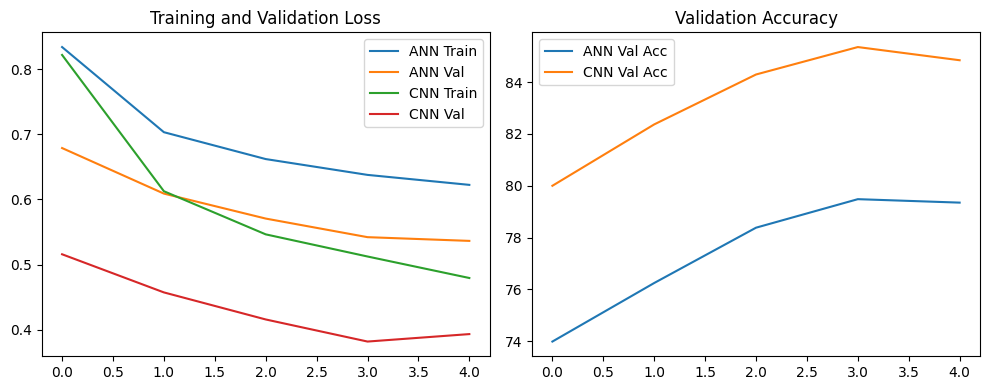

In [17]:
# --------------------------------------------------------------
# 7. Visualize Training Curves
# --------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ann_train_loss, label='ANN Train')
plt.plot(ann_val_loss, label='ANN Val')
plt.plot(cnn_train_loss, label='CNN Train')
plt.plot(cnn_val_loss, label='CNN Val')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ann_val_acc, label='ANN Val Acc')
plt.plot(cnn_val_acc, label='CNN Val Acc')
plt.title('Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# --------------------------------------------------------------
# 8. Final Comparison Summary
# --------------------------------------------------------------
print("\n========== FINAL ACCURACY COMPARISON ==========")
print(f"Improved ANN Test Accuracy : {ann_test_acc:.2f}%")
print(f"Improved CNN Test Accuracy : {cnn_test_acc:.2f}%")
print(f"Accuracy Difference        : {cnn_test_acc - ann_test_acc:.2f}%")

if cnn_test_acc > ann_test_acc:
    print(" CNN clearly outperforms ANN — thanks to spatial feature extraction and augmentation.")
else:
    print("NN matched or exceeded CNN — check augmentation or CNN tuning.")


========== FINAL ACCURACY COMPARISON ==========
Improved ANN Test Accuracy : 81.78%
Improved CNN Test Accuracy : 86.52%
Accuracy Difference        : 4.74%
 CNN clearly outperforms ANN — thanks to spatial feature extraction and augmentation.
